# Monster Identifier Project

This notebook outlines my attemopt at creating a CNN model that can identify and distinguish between various monsters/creatures from various sources such as Pokemon and Digimon.

## Importing Packages

In [ ]:
import sys
import zipfile
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.patches import Rectangle
import pandas as pd

from PIL import Image
import random

import shutil
from pathlib import Path

import os
import requests
from bs4 import BeautifulSoup
from urllib.parse import urljoin, urlparse
from PIL import Image
from io import BytesIO
import re

from collections import Counter

In [2]:
import tensorflow as tf
#print("TensorFlow version:", tf.__version__)
#print("GPU devices:", tf.config.list_physical_devices('GPU'))

from tensorflow.python.client import device_lib
#print(device_lib.list_local_devices())
#print(tf.sysconfig.get_build_info())

from tensorflow import keras

from tensorflow.keras import layers, models, regularizers

from PIL import Image
from tensorflow.keras.utils import Sequence
from tensorflow.keras import backend as K


2025-12-04 20:04:41.171393: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-04 20:04:41.246567: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-04 20:04:42.648646: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


# 1. Data Analysis and Processing

The data consists of images of monsters/creatures from Pokemon, Digimon, Yugioh, maplestory, palworld, and mosnterhunter. The pokemon and maple story images I got from kaggle datasets, while the rest I webscraped from various sources. My webscraping code can be seen in the github repository.

Pokemon:
    https://www.kaggle.com/datasets/kvpratama/pokemon-images-dataset

Maple Story: 
    https://www.kaggle.com/datasets/putskan/maplestory-monsters

Palworld: 
    https://palworld.fandom.com/wiki/Category:Images_-_Pals
    https://palworld.fandom.com/wiki/Alpha_Pals
    https://palworld.fandom.com/wiki/Breeding
    https://palworld.fandom.com/wiki/Lucky_Pals
    https://palworld.fandom.com/wiki/Legendary_Pals
    
Monster Hunter: 
    https://monsterhunter.fandom.com/wiki/Category:Monsters
    https://monsterhunter.fandom.com/wiki/Category:Photo_Galleries
    
YuGiOh:
    https://yugipedia.com/wiki/Category:Yu-Gi-Oh!_Duel_Links_monster_images
    https://yugipedia.com/index.php?title=Category:Yu-Gi-Oh!_Duel_Links_monster_images&filefrom=ArcanaForceXXITheWorld-DULI-EN-VG-NC.png#mw-category-media
    https://yugipedia.com/index.php?title=Category:Yu-Gi-Oh!_Duel_Links_monster_images&filefrom=BerserkGorilla-DULI-EN-VG-NC.png#mw-category-media
    
Digimon: 
    https://wikimon.net/Visual_List_of_Digimon



### Raw Data

The images are either jpg or png. They range from around 120x120 to around 256x256 (altough some are smaller). We have 819 pokemon, 1417 Digimon, 598 Yu-Gi-Oh, 1687 Maple story, 219 Palworld, and 669 Monster hunter images. I did not save the raw images to the github repo (because of their size), but they can be aquired using the webscraper notenook that's on there.

### Processed Data

I first started by manually going through all the images and removing any that looked wrong, such as concept art or shots from shows. Especially in my web-scraping, I may have accidentally downloaded incorrect photos. I tried my best to remove all of them, but some may have still slipped through.

I also removed all transparency and replaced transparent backgrounds with a white background. A few images do have gray or colored backgrounds, but they are minimal. We can avoid having the CNN model learn these features by adding some contrast and brightness data augmentation.

Finally, I rescaled all the images to 128 × 128. Scaling them up to 256 × 256 caused the lower-resolution images to appear blurry while others did not. I didn’t want the model to learn blurriness vs. crispness, so I instead scaled everything down to 128 × 128. This way, both higher-resolution and lower-resolution images look more consistent.

In [3]:
pokemon_jpg_path = Path("/home/wille/PythonProjects/Monsters/Data/pokemon_jpg/pokemon_jpg")
digimon_path = Path("/home/wille/PythonProjects/Monsters/Data/all_digimon_images")
ygo_path = Path("/home/wille/PythonProjects/Monsters/Data/all_yugioh_images")
maplestoy_path = Path("/home/wille/PythonProjects/Monsters/Data/maplestory_imgs")
palworld_path = Path("/home/wille/PythonProjects/Monsters/Data/all_palworld_images")
monsterhunter_path = Path("/home/wille/PythonProjects/Monsters/Data/all_monsterHunter_images")

dest_root = Path("/home/wille/PythonProjects/Monsters/Prepared")
dest_root.mkdir(exist_ok=True)


DATASETS = {
    "Pokémon": dest_root / "pokemon",
    "Digimon": dest_root / "digimon",
    "Yu-Gi-Oh": dest_root / "yugioh",
    "MapleStory" : dest_root / "maplestory",
    "Palworld" : dest_root / "palworld",
    "Monster Hunter" : dest_root / "monsterhunter",
}

In [ ]:
def sample_images(src_paths, n, dest_folder):
    dest_folder.mkdir(parents=True, exist_ok=True)

    # CLEAR DEST FOLDER
    for f in dest_folder.glob("*"):
        if f.is_file():
            f.unlink()

    print(f"🧹 Cleared {dest_folder}")

    all_files = []

    # Collect images
    for src_path in src_paths:
        print("Scanning:", src_path)

        for ext in ["*.png", "*.PNG", "*.jpg", "*.JPG", "*.jpeg", "*.JPEG"]:
            matches = list(src_path.rglob(ext))
            print(f"  Found {len(matches)} {ext} files")
            all_files.extend(matches)

    print("TOTAL FILES FOUND:", len(all_files))

    if len(all_files) == 0:
        print(" No images found.")
        return

    sampled = random.sample(all_files, min(n, len(all_files)))

    for i, f in enumerate(sampled):
        shutil.copy2(f, dest_folder / f"{i}_{f.name}")

    print(f" Copied {len(sampled)} images into {dest_folder}")

In [ ]:
sample_images([pokemon_jpg_path], 2000, dest_root / "pokemon")

sample_images([digimon_path], 2000, dest_root / "digimon")

sample_images([ygo_path], 2000, dest_root / "yugioh")

sample_images([maplestoy_path], 2000, dest_root / "maplestory")

sample_images([palworld_path], 2000, dest_root / "palworld")

sample_images([monsterhunter_path], 2000, dest_root / "monsterhunter")

print("Datasets prepared in:", dest_root)

🧹 Cleared /home/wille/PythonProjects/Monsters/Prepared/pokemon
Scanning: /home/wille/PythonProjects/Monsters/Data/pokemon_jpg/pokemon_jpg
  Found 0 *.png files
  Found 0 *.PNG files
  Found 819 *.jpg files
  Found 0 *.JPG files
  Found 0 *.jpeg files
  Found 0 *.JPEG files
TOTAL FILES FOUND: 819
 Copied 819 images into /home/wille/PythonProjects/Monsters/Prepared/pokemon
🧹 Cleared /home/wille/PythonProjects/Monsters/Prepared/digimon
Scanning: /home/wille/PythonProjects/Monsters/Data/all_digimon_images
  Found 37 *.png files
  Found 1 *.PNG files
  Found 1417 *.jpg files
  Found 5 *.JPG files
  Found 1 *.jpeg files
  Found 0 *.JPEG files
TOTAL FILES FOUND: 1461
 Copied 1461 images into /home/wille/PythonProjects/Monsters/Prepared/digimon
🧹 Cleared /home/wille/PythonProjects/Monsters/Prepared/yugioh
Scanning: /home/wille/PythonProjects/Monsters/Data/all_yugioh_images
  Found 598 *.png files
  Found 0 *.PNG files
  Found 0 *.jpg files
  Found 0 *.JPG files
  Found 0 *.jpeg files
  Found 0


===== Pokémon =====
Total images: 819



===== Digimon =====
Total images: 1461



===== Yu-Gi-Oh =====
Total images: 598



===== MapleStory =====
Total images: 1687


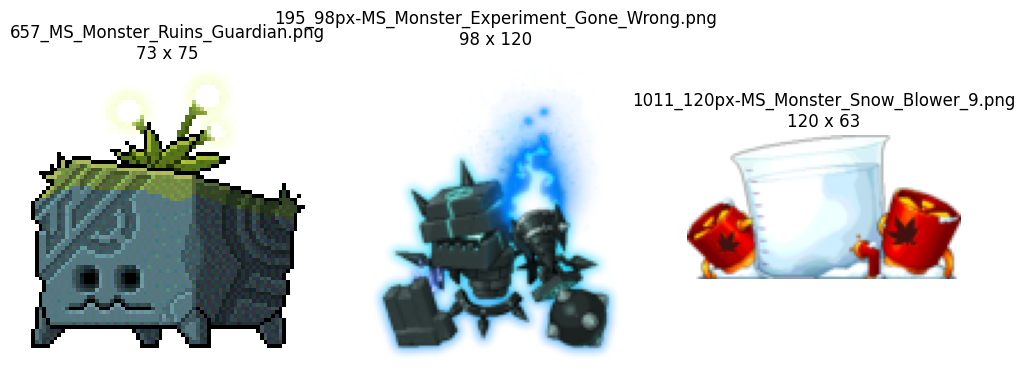


===== Palworld =====
Total images: 219


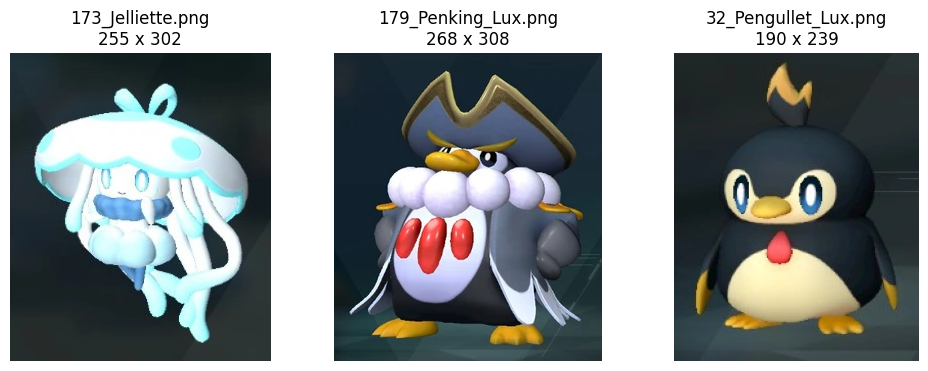


===== Monster Hunter =====
Total images: 733


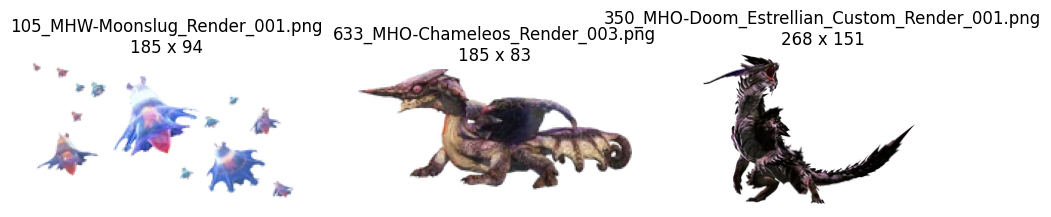

In [6]:
def explore_dataset(name, folder):
    files = list(folder.glob("*"))
    print(f"\n===== {name} =====")
    print("Total images:", len(files))

    # Pick 3 random images
    samples = random.sample(files, min(3, len(files)))
    fig, axes = plt.subplots(1, 3, figsize=(12,4))

    for ax, img_path in zip(axes, samples):
        img = Image.open(img_path)
        w, h = img.size

        ax.imshow(img)
        ax.set_title(f"{img_path.name}\n{w} x {h}")
        ax.axis("off")

    plt.show()

for name, folder in DATASETS.items():
    explore_dataset(name, folder)

In [7]:
def dataset_summary(name, folder):
    files = list(folder.glob("*"))

    print(f"\n===== {name.upper()} DATASET SUMMARY =====")
    print("Total images:", len(files))

    widths = []
    heights = []
    bad = 0

    for f in files:
        try:
            with Image.open(f) as img:
                w, h = img.size
                widths.append(w)
                heights.append(h)
        except:
            bad += 1

    widths = np.array(widths)
    heights = np.array(heights)

    print("Bad files:", bad)

    print("Width:")
    print("  Mean:", round(widths.mean(), 2))
    print("  Min:", widths.min())
    print("  Max:", widths.max())

    print("Height:")
    print("  Mean:", round(heights.mean(), 2))
    print("  Min:", heights.min())
    print("  Max:", heights.max())

    print("Aspect Ratio (W/H):")
    ratios = widths / heights
    print("  Mean:", round(ratios.mean(), 3))
    print("  Min:", round(ratios.min(), 3))
    print("  Max:", round(ratios.max(), 3))

for name, folder in DATASETS.items():
    dataset_summary(name, folder)


===== POKÉMON DATASET SUMMARY =====
Total images: 819
Bad files: 0
Width:
  Mean: 256.0
  Min: 256
  Max: 256
Height:
  Mean: 256.0
  Min: 256
  Max: 256
Aspect Ratio (W/H):
  Mean: 1.0
  Min: 1.0
  Max: 1.0

===== DIGIMON DATASET SUMMARY =====
Total images: 1461
Bad files: 0
Width:
  Mean: 240.0
  Min: 240
  Max: 240
Height:
  Mean: 238.97
  Min: 124
  Max: 342
Aspect Ratio (W/H):
  Mean: 1.007
  Min: 0.702
  Max: 1.935

===== YU-GI-OH DATASET SUMMARY =====
Total images: 598
Bad files: 0
Width:
  Mean: 110.31
  Min: 31
  Max: 120
Height:
  Mean: 108.44
  Min: 54
  Max: 120
Aspect Ratio (W/H):
  Mean: 1.059
  Min: 0.263
  Max: 2.222

===== MAPLESTORY DATASET SUMMARY =====
Total images: 1687
Bad files: 0
Width:
  Mean: 90.43
  Min: 21
  Max: 120
Height:
  Mean: 89.56
  Min: 22
  Max: 120
Aspect Ratio (W/H):
  Mean: 1.064
  Min: 0.224
  Max: 3.333

===== PALWORLD DATASET SUMMARY =====
Total images: 219
Bad files: 0
Width:
  Mean: 322.16
  Min: 151
  Max: 1095
Height:
  Mean: 333.12
  Mi

In [8]:
#TARGET = (256, 256)
TARGET = (128, 128)

def pad_to_square(img, fill=(255, 255, 255)):
    w, h = img.size
    side = max(w, h)

    new_img = Image.new("RGB", (side, side), fill)

    # center the original image
    paste_x = (side - w) // 2
    paste_y = (side - h) // 2
    new_img.paste(img, (paste_x, paste_y))

    return new_img

def resize_folder(folder):
    for img_path in folder.glob("*"):
        try:
            img = Image.open(img_path).convert("RGB")

            # 1) Pad image to square
            img = pad_to_square(img, fill=(255, 255, 255))

            # 2) Resize to target
            img = img.resize(TARGET, Image.LANCZOS)

            img.save(img_path)

        except Exception as e:
            print("Failed:", img_path, e)

def replace_transparent_pixels_in_folder(folder):
    for f in folder.glob("*"):
        try:
            img = Image.open(f)

            # Only process images with transparency
            if img.mode in ("RGBA", "LA") or ("transparency" in img.info):
                img = img.convert("RGBA")

                # Create solid white background
                white = Image.new("RGBA", img.size, (255, 255, 255, 255))

                # Blend using alpha channel
                combined = Image.alpha_composite(white, img)

                # Convert to RGB (removes transparency permanently)
                final = combined.convert("RGB")
                final.save(f)

        except Exception as e:
            print("❌ Failed:", f, e)


for name, folder in DATASETS.items():
    replace_transparent_pixels_in_folder(folder)
    resize_folder(folder)
    dataset_summary(name, folder)


===== POKÉMON DATASET SUMMARY =====
Total images: 819
Bad files: 0
Width:
  Mean: 128.0
  Min: 128
  Max: 128
Height:
  Mean: 128.0
  Min: 128
  Max: 128
Aspect Ratio (W/H):
  Mean: 1.0
  Min: 1.0
  Max: 1.0

===== DIGIMON DATASET SUMMARY =====
Total images: 1461
Bad files: 0
Width:
  Mean: 128.0
  Min: 128
  Max: 128
Height:
  Mean: 128.0
  Min: 128
  Max: 128
Aspect Ratio (W/H):
  Mean: 1.0
  Min: 1.0
  Max: 1.0

===== YU-GI-OH DATASET SUMMARY =====
Total images: 598
Bad files: 0
Width:
  Mean: 128.0
  Min: 128
  Max: 128
Height:
  Mean: 128.0
  Min: 128
  Max: 128
Aspect Ratio (W/H):
  Mean: 1.0
  Min: 1.0
  Max: 1.0

===== MAPLESTORY DATASET SUMMARY =====
Total images: 1687
Bad files: 0
Width:
  Mean: 128.0
  Min: 128
  Max: 128
Height:
  Mean: 128.0
  Min: 128
  Max: 128
Aspect Ratio (W/H):
  Mean: 1.0
  Min: 1.0
  Max: 1.0

===== PALWORLD DATASET SUMMARY =====
Total images: 219
Bad files: 0
Width:
  Mean: 128.0
  Min: 128
  Max: 128
Height:
  Mean: 128.0
  Min: 128
  Max: 128
As


===== Pokémon =====
Total images: 819


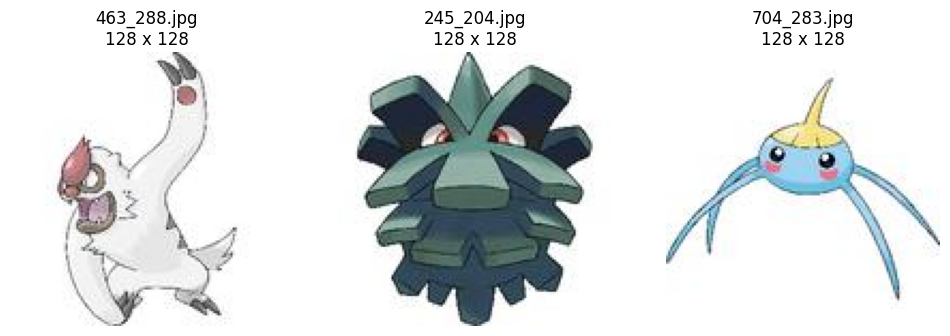


===== Digimon =====
Total images: 1461


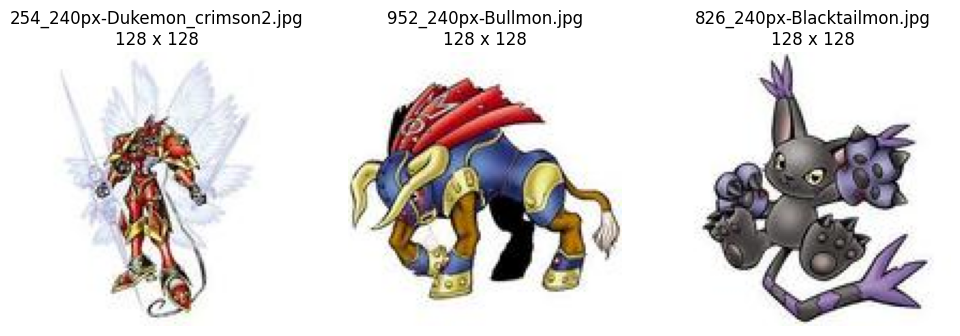


===== Yu-Gi-Oh =====
Total images: 598


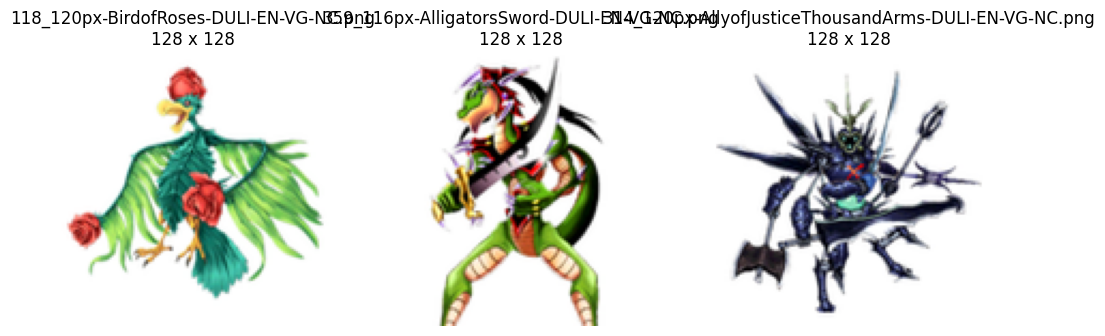


===== MapleStory =====
Total images: 1687



===== Palworld =====
Total images: 219


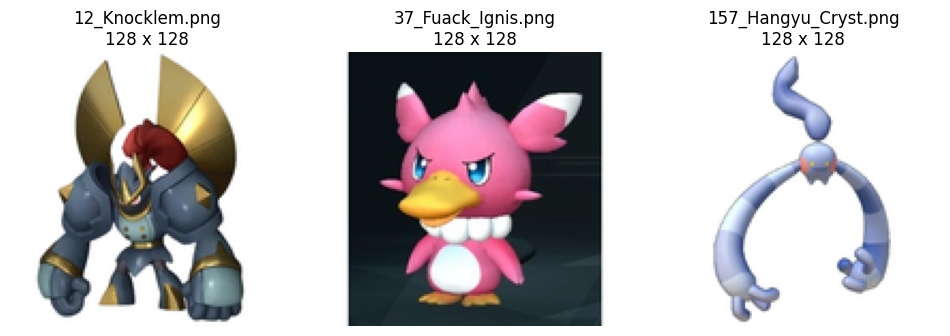


===== Monster Hunter =====
Total images: 733


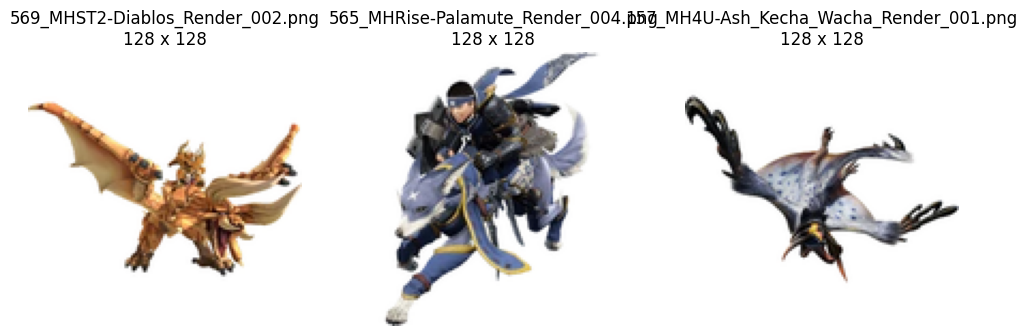

In [9]:
for name, folder in DATASETS.items():
    explore_dataset(name, folder)

Pokémon: 0 images have transparency
Pokémon: 139 images appear to have uniform backgrounds


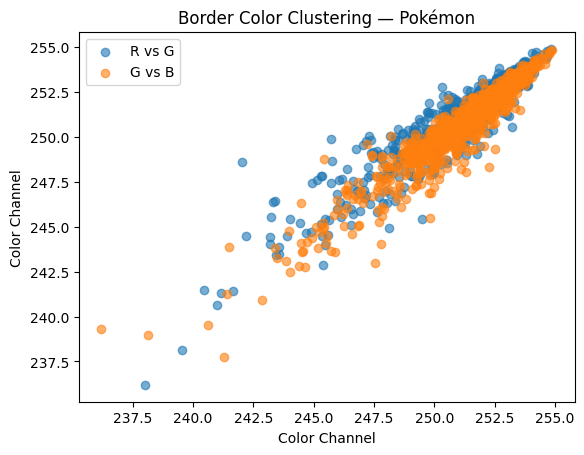

Digimon: 0 images have transparency
Digimon: 1403 images appear to have uniform backgrounds


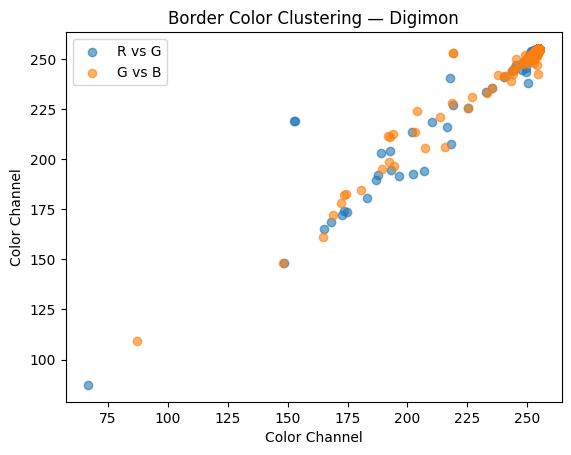

Yu-Gi-Oh: 0 images have transparency
Yu-Gi-Oh: 514 images appear to have uniform backgrounds


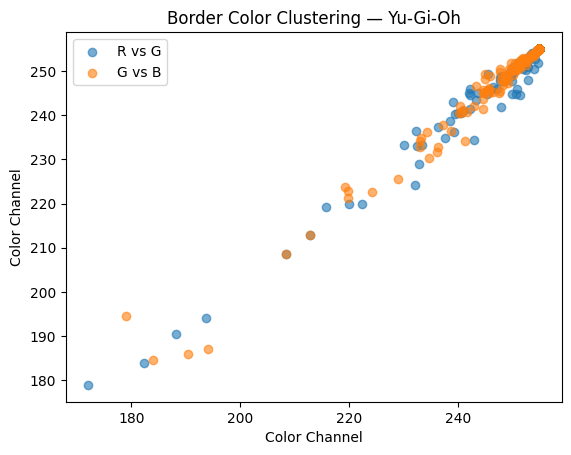

MapleStory: 0 images have transparency
MapleStory: 450 images appear to have uniform backgrounds


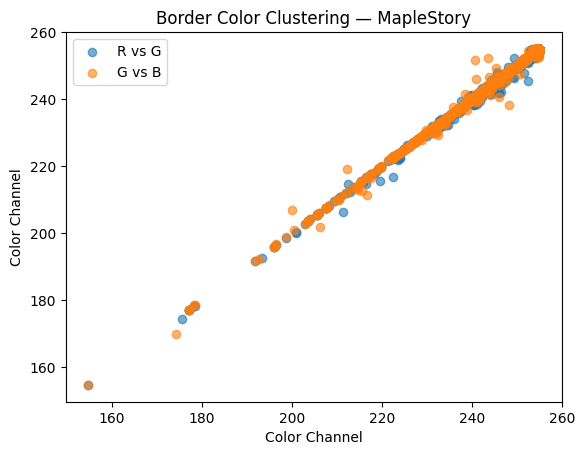

Palworld: 0 images have transparency
Palworld: 138 images appear to have uniform backgrounds


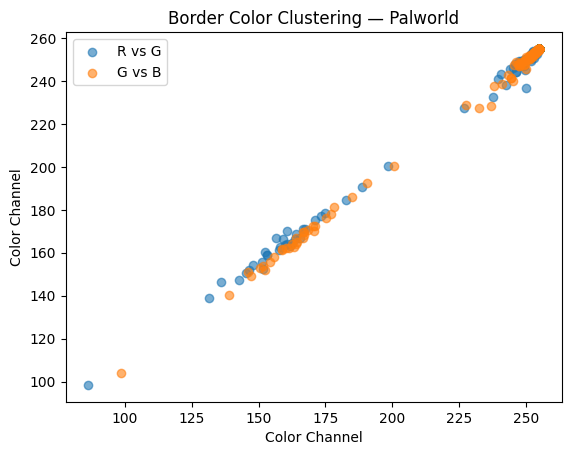

Monster Hunter: 0 images have transparency
Monster Hunter: 548 images appear to have uniform backgrounds


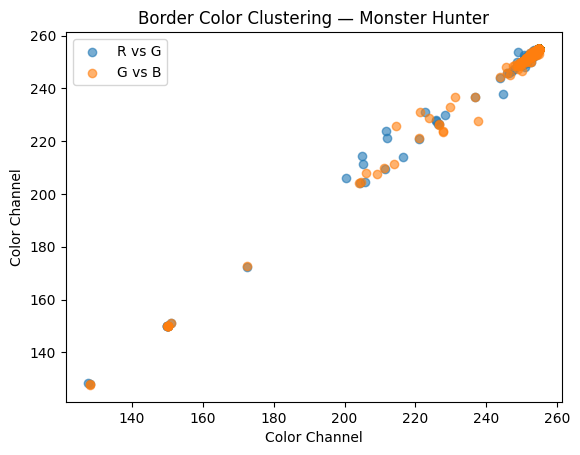

In [10]:
def check_transparency(name, folder):
    transparent = 0

    for f in folder.glob("*"):
        img = Image.open(f)
        if img.mode == "RGBA":
            alpha = np.array(img)[:,:,3]
            if np.any(alpha < 255):
                transparent += 1

    print(f"{name}: {transparent} images have transparency")

def background_uniformity(name, folder, threshold=12):
    uniform = 0

    for f in folder.glob("*"):
        img = Image.open(f).convert("RGB")
        arr = np.array(img)

        # Collect border pixels
        border = np.concatenate([
            arr[0,:,:],
            arr[-1,:,:],
            arr[:,0,:],
            arr[:,-1,:]
        ])

        std = border.std()
        if std < threshold:
            uniform += 1

    print(f"{name}: {uniform} images appear to have uniform backgrounds")

def plot_background_colors(name, folder):
    colors = []

    for f in folder.glob("*"):
        img = Image.open(f).convert("RGB")
        arr = np.array(img)

        border = np.concatenate([
            arr[0,:,:],
            arr[-1,:,:],
            arr[:,0,:],
            arr[:,-1,:]
        ])

        colors.append(border.mean(axis=0))

    colors = np.array(colors)

    plt.scatter(colors[:,0], colors[:,1], label="R vs G", alpha=0.6)
    plt.scatter(colors[:,1], colors[:,2], label="G vs B", alpha=0.6)
    plt.title(f"Border Color Clustering — {name}")
    plt.xlabel("Color Channel")
    plt.ylabel("Color Channel")
    plt.legend()
    plt.show()


for name, folder in DATASETS.items():
    check_transparency(name, folder)
    background_uniformity(name, folder)
    plot_background_colors(name, folder)

## Train, Validation, and Test split

Here, I split the data into training, testing, and validation sets. I go for a 0.7, 0.2, 0.1 split. Since we don't hgave equal number of iamges per category, I also calculate the class weights.

In [ ]:
IMG_SIZE = (128, 128)
BATCH_SIZE = 4

#class_names = ["pokemon", "digimon", "yugioh", "maplestory"]
class_names = ["Digimon", "MapleStory", "Monster Hunter", "Palworld", "Pokémon", "Yu-Gi-Oh"]

for split in ["train", "val", "test"]:
    folder = dest_root / split
    if folder.exists():
        shutil.rmtree(folder) 

splits = ["train", "val", "test"]
train_ratio, val_ratio, test_ratio = 0.7, 0.2, 0.1

for split in splits:
    for class_name in DATASETS.keys():
        (dest_root / split / class_name).mkdir(parents=True, exist_ok=True)

# Shuffle and copy files
for class_name, class_path in DATASETS.items():
    files = list(class_path.glob("*.[pj][np]g"))
    random.shuffle(files)
    n = len(files)
    n_train = int(train_ratio * n)
    n_val = int(val_ratio * n)

    for i, f in enumerate(files):
        if i < n_train:
            dest = dest_root / "train" / class_name / f.name
        elif i < n_train + n_val:
            dest = dest_root / "val" / class_name / f.name
        else:
            dest = dest_root / "test" / class_name / f.name
        shutil.copy(f, dest)

train_ds = tf.keras.utils.image_dataset_from_directory(
    dest_root / "train",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    labels="inferred",
    label_mode="categorical",
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    dest_root / "val",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    labels="inferred",
    label_mode="categorical",
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    dest_root / "test",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    labels="inferred",
    label_mode="categorical",
    shuffle=False
)

Found 3846 files belonging to 6 classes.


I0000 00:00:1764896709.706543   18138 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5590 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060 Ti, pci bus id: 0000:01:00.0, compute capability: 8.6


Found 1096 files belonging to 6 classes.
Found 557 files belonging to 6 classes.


In [ ]:
def count_images(folder):
    counts = {}
    for class_dir in folder.iterdir():
        if class_dir.is_dir():
            counts[class_dir.name] = len(list(class_dir.glob("*")))
    return counts

#Coutn agian
print("TRAIN:", count_images(dest_root / "train"))
print("VAL:  ", count_images(dest_root / "val"))
print("TEST: ", count_images(dest_root / "test"))

TRAIN: {'Pokémon': 573, 'Monster Hunter': 505, 'MapleStory': 1180, 'Digimon': 1017, 'Palworld': 153, 'Yu-Gi-Oh': 418}
VAL:   {'Pokémon': 163, 'Monster Hunter': 144, 'MapleStory': 337, 'Digimon': 290, 'Palworld': 43, 'Yu-Gi-Oh': 119}
TEST:  {'Pokémon': 83, 'Monster Hunter': 73, 'MapleStory': 170, 'Digimon': 147, 'Palworld': 23, 'Yu-Gi-Oh': 61}


In [ ]:
train_counts = {}

for i, class_name in enumerate(class_names):
    count = count_images(dest_root / "train")[class_name]
    train_counts[i] = count

total = sum(train_counts.values())
num_classes = len(train_counts)

class_weights = {}

for cls, count in train_counts.items():
    class_weights[cls] = total / (num_classes * count)

print("Class weights:")
for k, v in class_weights.items():
    print(class_names[k], "->", round(v, 3))

Class weights:
Digimon -> 0.63
MapleStory -> 0.543
Monster Hunter -> 1.269
Palworld -> 4.19
Pokémon -> 1.119
Yu-Gi-Oh -> 1.533


In [17]:
def normalize_img(image, label):
    image = tf.cast(image, tf.float32) / 255.0  # scale to [0,1]
    return image, label

train_ds = train_ds.map(normalize_img)
val_ds = val_ds.map(normalize_img)
test_ds = test_ds.map(normalize_img)

### Data Augmentation. 

Since we want the model to pick up the specific characteristics of the monsters themselves, we add data augmentation to prevent it from learning “cheating” features. For example, because some groups may occasionally contain images with gray or dark backgrounds rather than white, we apply minor contrast and brightness adjustments.

Also, some categories contain only full-body monster images, while others include cropped versions. For example, the Pokémon images are all full-profile images, but some Yu-Gi-Oh! images may show only the top half of the monster. Since I don’t want the model learning these cropped-edge features, I add random zoom and translation augmentations.

In [18]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.05),
    layers.RandomZoom(0.06),
    layers.RandomTranslation(0.06, 0.06),
    layers.RandomContrast(0.0005),
    layers.RandomBrightness(0.0005),
])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.09130811..1.0908723].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.19290413..1.0983186].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.09359805..1.0456234].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.12039356..1.0509306].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.09084191..1.0141072].


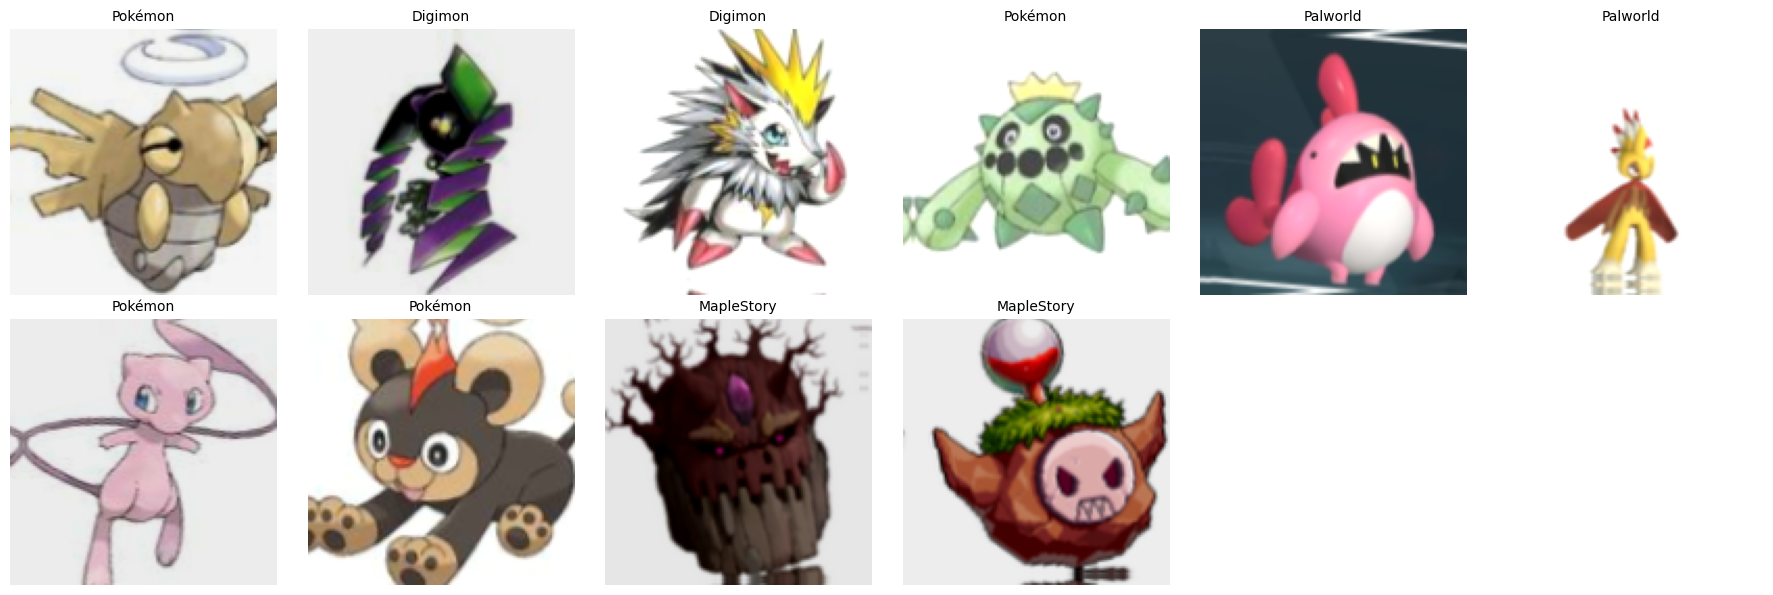

In [ ]:
import math

num_images = 10 

batched = train_ds.unbatch().batch(num_images)
images_batch, labels_batch = next(iter(batched))

augmented = data_augmentation(images_batch, training=True)

augmented_np = augmented.numpy()            # shape: (N, H, W, C)
labels_np = labels_batch.numpy()            # could be shape (N,) or (N, num_classes)

num_images = min(num_images, augmented_np.shape[0])

cols = min(6, num_images)
rows = math.ceil(num_images / cols)

plt.figure(figsize=(cols * 3, rows * 3))

for i in range(num_images):
    ax = plt.subplot(rows, cols, i + 1)

    img = augmented_np[i]
    plt.imshow(img)
    plt.axis("off")

    lab = labels_np[i]

    if lab.ndim > 0 and lab.shape != (): 
        if lab.size > 1:
            label_idx = int(np.argmax(lab))
        else:
            scalar = lab.item()
            if isinstance(scalar, (bytes, bytearray)):
                label_name = scalar.decode()
                plt.title(label_name, fontsize=10)
                continue
            else:
                label_idx = int(scalar)
    else:
        scalar = lab.item()
        if isinstance(scalar, (bytes, bytearray)):
            label_name = scalar.decode()
            plt.title(label_name, fontsize=10)
            continue
        else:
            label_idx = int(scalar)

    plt.title(class_names[label_idx], fontsize=10)

plt.tight_layout()
plt.show()

In [ ]:
#Add Callback block

num_classes = len(DATASETS)

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

callbacks = [
        EarlyStopping(
            monitor='val_loss',
            patience=10,
            restore_best_weights=True,
            verbose=1
        ),

        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=5,
            verbose=1,
            min_lr=1e-6
        ),

        ModelCheckpoint(
            "creature_classifier_best.h5",
            monitor='val_accuracy',
            save_best_only=True,
            verbose=1
        )
    ]

## Model training

I ended up training and trying five different models to see what worked best.

The first 2 models are simple CNN models with 4 convolutional layers. For Models 3 and 4 I tried adding some residual and inception layers. And finally model 5 was a sort of residual-inception hybrid model. I found that my first model, which was also the simplest and most basic, worked the best. This model contained 4 convolutional blocks, global pooling, and a final dense classifier layer.

In [21]:
model_1 = models.Sequential([
    layers.Input(shape=(*IMG_SIZE, 3), name="input"),

    data_augmentation,

    # Block 0
    layers.Conv2D(32, 3, padding="same", activation="relu",
                  kernel_regularizer=tf.keras.regularizers.l2(1e-4),
                  name="block0_conv"),
    layers.BatchNormalization(name="block0_n"),
    layers.MaxPooling2D(name="block0_pool"),

    # Block 1
    layers.Conv2D(64, 3, padding="same", activation="relu",
                  kernel_regularizer=tf.keras.regularizers.l2(1e-4),
                  name="block1_conv"),
    layers.BatchNormalization(name="bloc1_n"),
    layers.MaxPooling2D(name="block1_pool"),

    # Block 2
    layers.Conv2D(128, 3, padding="same", activation="relu",
                  kernel_regularizer=tf.keras.regularizers.l2(1e-4),
                  name="block2_conv"),
    layers.BatchNormalization(name="block2_n"),
    layers.MaxPooling2D(name="block2_pool"),

    # Block 3
    layers.Conv2D(256, 3, padding="same", activation="relu",
                  kernel_regularizer=tf.keras.regularizers.l2(1e-4),
                  name="block3_conv"),
    layers.BatchNormalization(name="block3_n"),
    layers.MaxPooling2D(name="block3_pool"),

    
    # Global pooling
    layers.GlobalAveragePooling2D(),

    # Dense classifier
    layers.Dense(256, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation="softmax"),
])

model_1.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
    metrics=['accuracy']
)

#model.summary()

callbacks = [
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1),
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, min_lr=1e-6),
        tf.keras.callbacks.ModelCheckpoint("creature_classifier_best.keras", monitor='val_accuracy', save_best_only=True, verbose=1)
    ]

history_1 = model_1.fit(
    train_ds,
    validation_data=val_ds,
    epochs=60,
    class_weight=class_weights,
    callbacks=callbacks
)

Epoch 1/60


2025-12-04 20:05:16.419028: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91500


962/962 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.2868 - loss: 1.8611
Epoch 1: val_accuracy improved from None to 0.31934, saving model to creature_classifier_best.keras
962/962 ━━━━━━━━━━━━━━━━━━━━ 24s 21ms/step - accuracy: 0.3396 - loss: 1.7302 - val_accuracy: 0.3193 - val_loss: 2.4795 - learning_rate: 1.0000e-04
Epoch 2/60
960/962 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.4095 - loss: 1.6009
Epoch 2: val_accuracy improved from 0.31934 to 0.38777, saving model to creature_classifier_best.keras
962/962 ━━━━━━━━━━━━━━━━━━━━ 22s 23ms/step - accuracy: 0.4368 - loss: 1.5494 - val_accuracy: 0.3878 - val_loss: 2.0665 - learning_rate: 1.0000e-04
Epoch 3/60
961/962 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.4945 - loss: 1.4671
Epoch 3: val_accuracy did not improve from 0.38777
962/962 ━━━━━━━━━━━━━━━━━━━━ 22s 22ms/step - accuracy: 0.4893 - loss: 1.4515 - val_accuracy: 0.3832 - val_loss: 3.9128 - learning_rate: 1.0000e-04
Epoch 4/60
962/962 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - 

In [ ]:
model_2 = models.Sequential([
    layers.Input(shape=(*IMG_SIZE, 3), name="input"),

    data_augmentation,

    # Block 0
    layers.Conv2D(64, 3, padding="same", activation="relu",
                  kernel_regularizer=tf.keras.regularizers.l2(1e-4),
                  name="block0_conv"),
    layers.BatchNormalization(name="block0_n"),
    layers.MaxPooling2D(name="block0_pool"),

    # Block 1
    layers.Conv2D(128, 3, padding="same", activation="relu",
                  kernel_regularizer=tf.keras.regularizers.l2(1e-4),
                  name="block1_conv"),
    layers.BatchNormalization(name="bloc1_n"),
    layers.MaxPooling2D(name="block1_pool"),

    # Block 2
    layers.Conv2D(256, 3, padding="same", activation="relu",
                  kernel_regularizer=tf.keras.regularizers.l2(1e-4),
                  name="block2_conv"),
    layers.BatchNormalization(name="block2_n"),
    layers.MaxPooling2D(name="block2_pool"),

    # Block 3
    layers.Conv2D(512, 3, padding="same", activation="relu",
                  kernel_regularizer=tf.keras.regularizers.l2(1e-4),
                  name="block3_conv"),
    layers.BatchNormalization(name="block3_n"),
    layers.MaxPooling2D(name="block3_pool"),

    
    # Global pooling
    layers.GlobalAveragePooling2D(),

    # Dense classifier
    layers.Dense(512, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation="softmax"),
])

model_2.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
    metrics=['accuracy']
)

#model.summary()

history_2 = model_2.fit(
    train_ds,
    validation_data=val_ds,
    epochs=60,
    callbacks=callbacks,
    class_weight=class_weights
)

In [ ]:
# Inception module
def inception_module(x, filters_1x1, filters_3x3, filters_5x5, filters_pool):
    #1-1
    path1 = layers.Conv2D(filters_1x1, (1,1), padding='same', activation=None)(x)
    path1 = layers.BatchNormalization()(path1)
    path1 = layers.ReLU()(path1)

    #1-1 to 3-3 
    path2 = layers.Conv2D(filters_3x3[0], (1,1), padding='same', activation=None)(x)
    path2 = layers.BatchNormalization()(path2)
    path2 = layers.ReLU()(path2)
    path2 = layers.Conv2D(filters_3x3[1], (3,3), padding='same', activation=None)(path2)
    path2 = layers.BatchNormalization()(path2)
    path2 = layers.ReLU()(path2)

    #1-1 to 5-5
    path3 = layers.Conv2D(filters_5x5[0], (1,1), padding='same', activation=None)(x)
    path3 = layers.BatchNormalization()(path3)
    path3 = layers.ReLU()(path3)
    path3 = layers.Conv2D(filters_5x5[1], (5,5), padding='same', activation=None)(path3)
    path3 = layers.BatchNormalization()(path3)
    path3 = layers.ReLU()(path3)

    # 3-3 to 1-1
    path4 = layers.MaxPooling2D((3,3), strides=(1,1), padding='same')(x)
    path4 = layers.Conv2D(filters_pool, (1,1), padding='same', activation=None)(path4)
    path4 = layers.BatchNormalization()(path4)
    path4 = layers.ReLU()(path4)

    return layers.concatenate([path1, path2, path3, path4], axis=-1)

def residual_block(x, filters, kernel_size=3):
    shortcut = x
    x = layers.Conv2D(filters, kernel_size, padding='same', activation=None)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(filters, kernel_size, padding='same', activation=None)(x)
    x = layers.BatchNormalization()(x)

    # Match dim
    if shortcut.shape[-1] != filters:
        shortcut = layers.Conv2D(filters, (1,1), padding='same')(shortcut)
    x = layers.Add()([x, shortcut])
    x = layers.ReLU()(x)
    return x

In [ ]:
from tensorflow.keras import Input, Model

input_layer= Input(shape=(128,128,3)) 
x = data_augmentation(input_layer)

# --- Stem ---
x = layers.Conv2D(32, 3, activation="relu", padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D()(x)

# --- Residual Blocks ---
x = residual_block(x, 64)
x = layers.MaxPooling2D()(x)

x = residual_block(x, 128)
x = layers.MaxPooling2D()(x)

# --- Feature Head ---
x = layers.Conv2D(256, 3, activation="relu", padding="same")(x)
x = layers.BatchNormalization()(x)

# --- Global Pooling ---
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dropout(0.5)(x)

output = layers.Dense(num_classes, activation="softmax")(x)

model_3 = Model(inputs=input_layer, outputs=output)

model_3.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
    metrics=['accuracy']
) 

#model.summary()

history_3 = model_3.fit(
    train_ds,
    validation_data=val_ds,
    epochs=60,
    callbacks=callbacks,
    class_weight=class_weights
)

In [ ]:
input_layer = Input(shape=(128,128,3))
x = data_augmentation(input_layer)

# --- Stem ---
x = layers.Conv2D(32, 3, activation="relu", padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D()(x)

# --- Inception Stack ---
x = inception_module(x, filters_1x1=32, filters_3x3=(32,64), filters_5x5=(16,32), filters_pool=32)
x = layers.MaxPooling2D()(x)

x = inception_module(x, filters_1x1=64, filters_3x3=(64, 128), filters_5x5=(32, 64), filters_pool=64 ) 
x = layers.MaxPooling2D()(x)

x = inception_module(x, filters_1x1=128, filters_3x3=(128, 256), filters_5x5=(64, 128), filters_pool=128 ) 
x = layers.MaxPooling2D()(x)

x = inception_module(x, filters_1x1=256, filters_3x3=(256, 512), filters_5x5=(128, 256), filters_pool=256 ) 
x = layers.MaxPooling2D()(x)

# --- Feature Reduction ---
x = layers.Conv2D(512, 3, activation="relu", padding="same")(x)
x = layers.BatchNormalization()(x)

# --- Classifier ---
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(512, activation="relu")(x)
x = layers.Dropout(0.5)(x)

output = layers.Dense(num_classes, activation="softmax")(x)

# --- Final Model ---
model_4 = Model(inputs=input_layer, outputs=output)

model_4.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
    metrics=['accuracy']
)

#model.summary()

history_4 = model_4.fit(
    train_ds,
    validation_data=val_ds,
    epochs=60,
    callbacks=callbacks,
    class_weight=class_weights
)


In [ ]:
opti = tf.keras.optimizers.Adam(learning_rate=1e-5) 
input_layer = Input(shape=(128,128,3)) 
x = data_augmentation(input_layer) 
# Initial Conv 
x = layers.Conv2D(64, (3,3), padding='same', activation='relu')(x) 
x = layers.MaxPooling2D((2,2))(x) 

# Inception + Residual 
x = inception_module(x, filters_1x1=32, filters_3x3=(32,64), filters_5x5=(16,32), filters_pool=32)
x = residual_block(x, 64) 
x = layers.MaxPooling2D((2,2))(x) 

x = inception_module(x, filters_1x1=64, filters_3x3=(64, 128), filters_5x5=(32, 64), filters_pool=64 ) 
x = residual_block(x, 128) 
x = layers.MaxPooling2D((2,2))(x) 

x = inception_module(x, filters_1x1=128, filters_3x3=(128, 256), filters_5x5=(64, 128), filters_pool=128 ) 
x = residual_block(x, 256) 
x = layers.MaxPooling2D((2,2))(x) 

x = layers.GlobalAveragePooling2D()(x) 
x = layers.Dropout(0.5)(x) 
x = layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(x) 
x = layers.Dropout(0.5)(x) 
output = layers.Dense(6, activation='softmax', kernel_regularizer=regularizers.l2(1e-4))(x) 

model_5 = Model(inputs=input_layer, outputs=output) 

model_5.compile( optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1), metrics=['accuracy',] ) 
# Train 
history_5 = model_5.fit( train_ds, validation_data=val_ds, epochs=50, callbacks=callbacks, class_weight=class_weights )

## Results

I then plotted the accuraies over Epochs and found that the forst model worked the best. I also plotted a few example images and the confusion matrix for the first model only.

In [ ]:
histories = [
    history_1,
    history_2,
    history_3,
    history_4,
    history_5,
]

model_names = [
    "Model 1", "Model 2", "Model 3", "Model 4", "Model 5"
]

num_models = len(histories)

# Create a 2x4 grid of subplots
fig, axes = plt.subplots(3, 2, figsize=(10, 8))
axes = axes.flatten()  # Make indexing easier

for i in range(num_models):
    ax = axes[i]
    history = histories[i]

    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    epochs = range(1, len(acc) + 1)

    ax.plot(epochs, acc, label="Train Acc")
    ax.plot(epochs, val_acc, label="Val Acc")

    ax.set_title(model_names[i])
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Accuracy")
    ax.legend()
    ax.grid(True)

# Hide unused subplots if fewer than 8 models
for i in range(num_models, 3):
    axes[i].axis("off")

plt.suptitle("Training and Validation Accuracy per Model", fontsize=16)
plt.tight_layout()
plt.show()

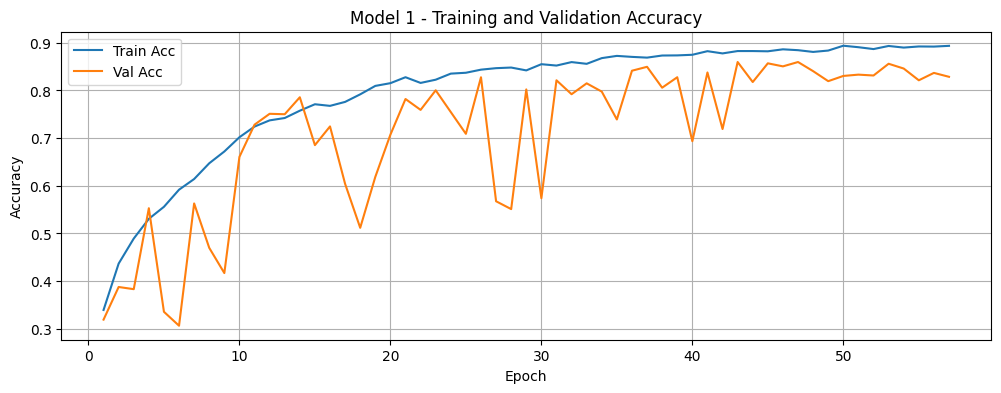

In [24]:
acc = history_1.history['accuracy']
val_acc = history_1.history['val_accuracy']
epochs = range(1, len(acc) + 1)

# Single plot
plt.figure(figsize=(12, 4))
plt.plot(epochs, acc, label="Train Acc")
plt.plot(epochs, val_acc, label="Val Acc")

plt.title("Model 1 - Training and Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

num_classes: 6
len(class_names): 6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


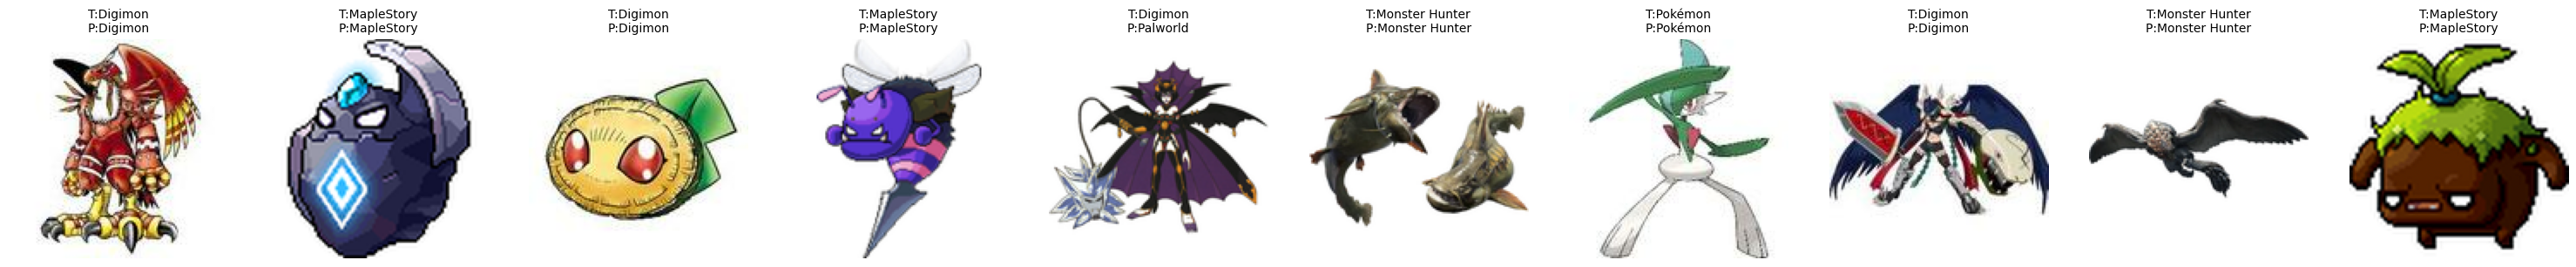

In [27]:
num_images = 10

print("num_classes:", num_classes)
print("len(class_names):", len(class_names))

# Collect all images and labels from the test dataset
all_images = []
all_labels = []
for images, labels in test_ds.unbatch():
    all_images.append(images.numpy())
    all_labels.append(labels.numpy())

# Randomly sample num_images indices
sample_indices = random.sample(range(len(all_images)), num_images)

# Create subplots
fig, axes = plt.subplots(1, num_images, figsize=(3*num_images, 3))

for i, idx in enumerate(sample_indices):
    img = all_images[idx]
    true_label_idx = np.argmax(all_labels[idx])
    true_label_name = class_names[true_label_idx]

    pred_idx = np.argmax(model_1.predict(tf.expand_dims(img, axis=0)))
    pred_label_name = class_names[pred_idx]

    ax = axes[i]
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(f"T:{true_label_name}\nP:{pred_label_name}", fontsize=10)

plt.tight_layout()
plt.show()

In [28]:
from sklearn.metrics import accuracy_score

In [29]:
train_acc = history_1.history['accuracy']
val_acc = history_1.history['val_accuracy']

# Best values
best_train_acc = np.max(train_acc)
best_val_acc = np.max(val_acc)

print(f"Best Training Accuracy: {best_train_acc:.4f}")
print(f"Best Validation Accuracy: {best_val_acc:.4f}")

Best Training Accuracy: 0.8937
Best Validation Accuracy: 0.8595


In [30]:
# Get predictions
y_pred_probs = model_1.predict(test_ds)
y_pred = np.argmax(y_pred_probs, axis=1)

# 2. True labels
y_true = np.concatenate([np.argmax(y.numpy(), axis=1) for x, y in test_ds], axis=0)

# 3. Accuracy
acc = accuracy_score(y_true, y_pred)
print(f"Test accuracy: {acc:.4f}")

140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Test accuracy: 0.8725


2025-12-04 20:28:29.975476: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [32]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

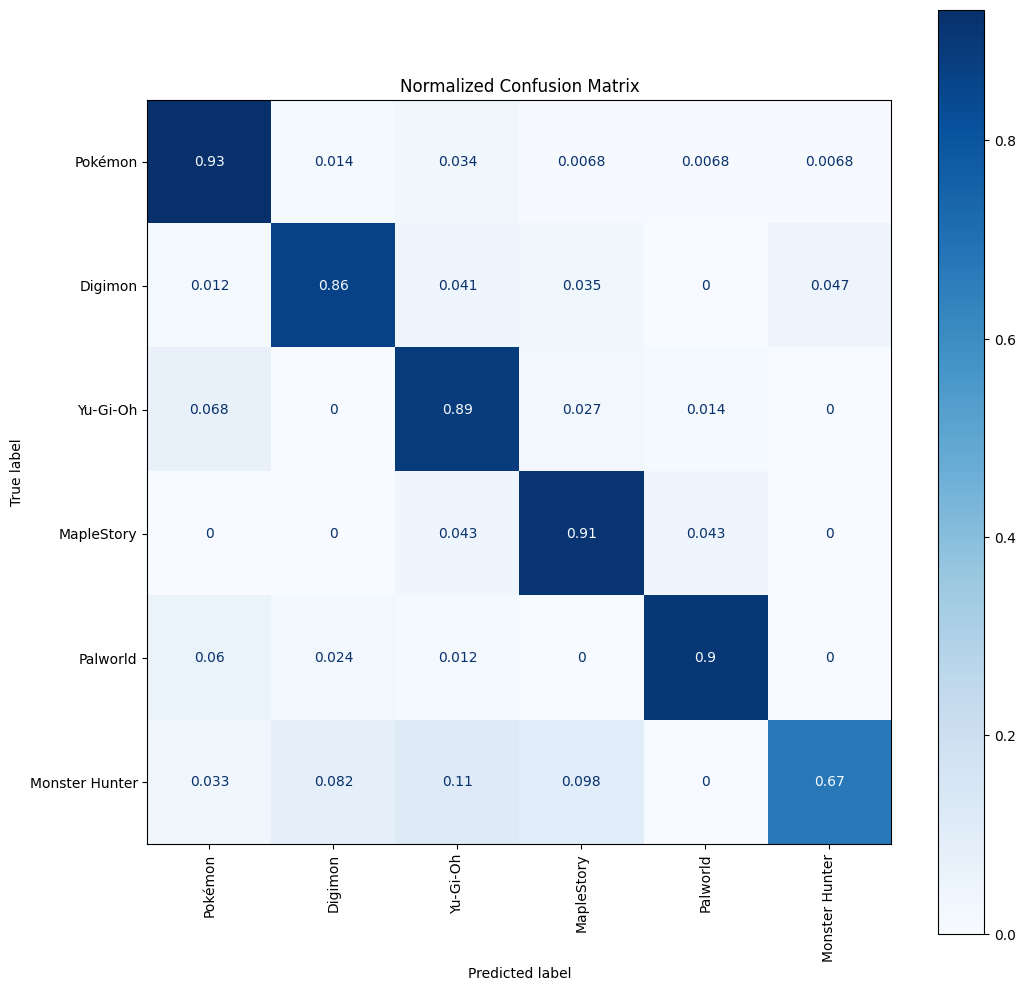

In [33]:
cm = confusion_matrix(y_true, y_pred)

cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# 3. Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalized,
                              display_labels=DATASETS)  # assuming DATASETS has class names
fig, ax = plt.subplots(figsize=(12,12))  # adjust size for readability
disp.plot(ax=ax, cmap=plt.cm.Blues, xticks_rotation='vertical')
plt.title("Normalized Confusion Matrix")
plt.show()

## Conclusion

In conclusion we were able to get above 80% accuracy for training, validation, and testing data. The hardest group to identify was the monster hunter group which makes sense since I took images from across several monster hunter games. OVer the years, the designs and art styles of teh monsters changed, making it harder to identify. I did this in orderto have a larger quantity of images. 

Future works could include:

-Implement images from a wider range of generations (eg: Older and new pokemon images/styles)
-Organize the images classes into further subclasses based on generation (eg: Separate monster hunter images into Monster Hunter Rise and World)
-Include images with more unique backgrounds (eg: shots from shows or with background art)


## Bonus:

As a little bonus, I also plotted the various visualizations of the filters.

I0000 00:00:1764898190.474999   18138 cuda_solvers.cc:175] Creating GpuSolver handles for stream 0x453438d0


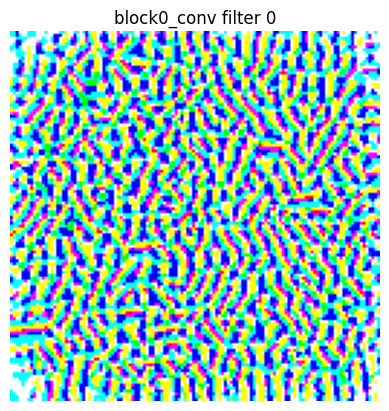

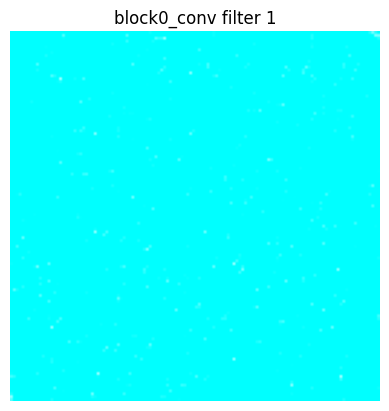

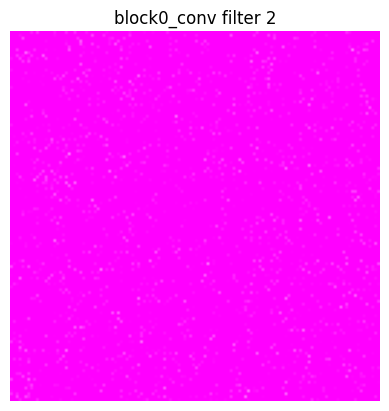

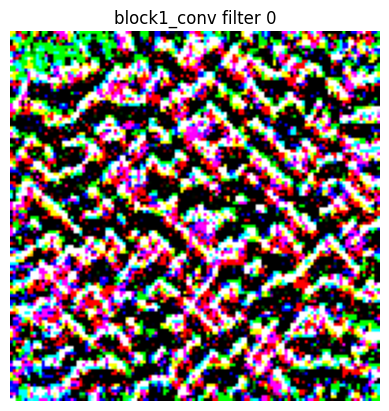

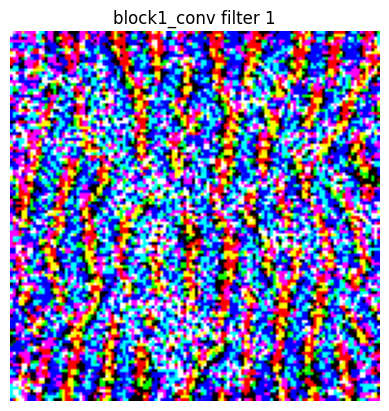

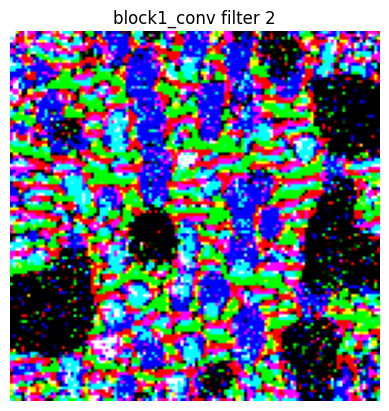

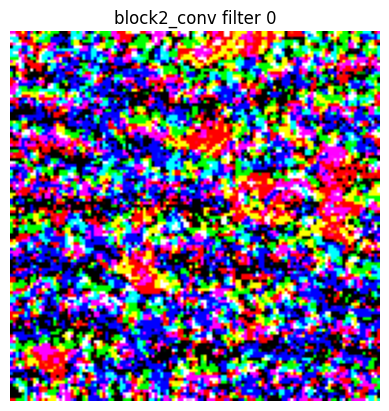

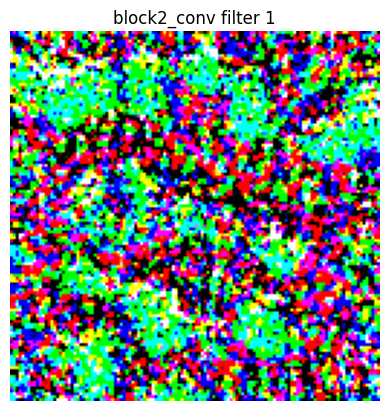

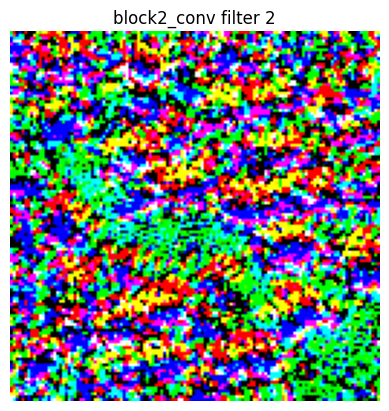

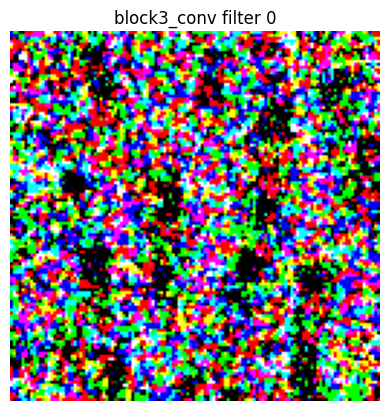

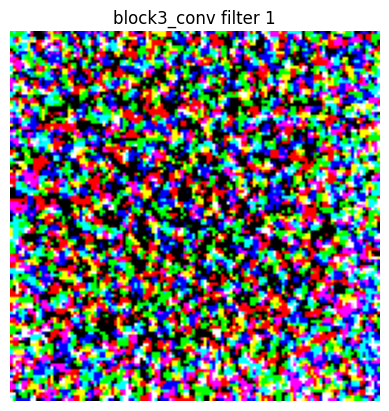

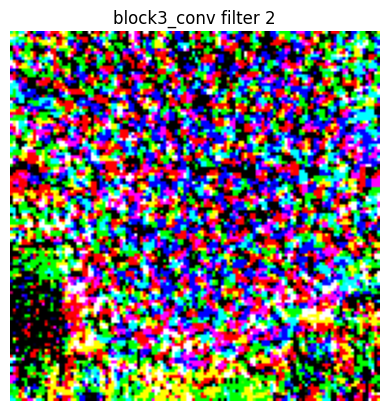

In [ ]:
def visualize_filter(model, layer_name, filter_index, steps=40, step_size=1.0):
    target_layer = model.get_layer(layer_name)

    # Create new Input tensor
    input_tensor = tf.keras.Input(shape=(*IMG_SIZE, 3))
    
    # Pass it through the model
    x = input_tensor
    for layer in model.layers:
        x = layer(x)
        if layer.name == layer_name:
            break
    
    sub_model = tf.keras.Model(inputs=input_tensor, outputs=x)

    # Start random noise
    input_img_data = tf.random.uniform((1, *IMG_SIZE, 3))

    for i in range(steps):
        with tf.GradientTape() as tape:
            tape.watch(input_img_data)
            activation = sub_model(input_img_data)
            loss_value = tf.reduce_mean(activation[..., filter_index])

        grads = tape.gradient(loss_value, input_img_data)
        grads /= (tf.math.reduce_std(grads) + 1e-8)
        input_img_data += grads * step_size

    img = np.clip(input_img_data[0], 0, 1)
    plt.imshow(img)
    plt.title(f"{layer_name} filter {filter_index}")
    plt.axis('off')
    plt.show()

dummy_input = tf.random.uniform((1, *IMG_SIZE, 3))
_ = model_1(dummy_input)

conv_layer_names = ['block0_conv', 'block1_conv', 'block2_conv', 'block3_conv']

for layer_name in conv_layer_names:
    for filter_index in range(3):
        visualize_filter(model_1, layer_name=layer_name, filter_index=filter_index)